In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import operator

# Fault Condition 1 is for a variable fan (units of speed command in %) controlling to a duct pressure sensor setpoint (units in Inches Water Column)

# Snip of ASHRAE Fault Condition 1 definition related to AHU Fan Speed and Duct Pressure Control

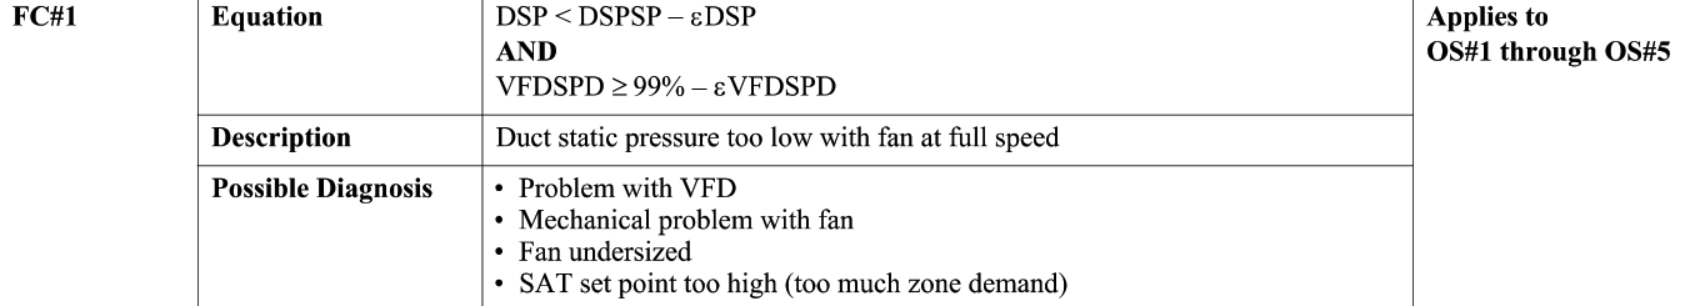

In [2]:
# Equation returns Boolean True Or False

def fault_condition_one(dataframe):
    return operator.and_(dataframe.duct_static < dataframe.duct_static_setpoint, dataframe.vfd_speed >= dataframe.vfd_speed_percent_max)


# Read Associated CSV files forward fill dataset and remove NaNs

In [3]:
rtu_duct_pressure = pd.read_csv('./summer_data/RTU Duct Static Pressure-data-as-seriestocolumns-2021-11-06 07_21_53.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()
rtu_fan_speed = pd.read_csv('./summer_data/RTU Supply Fan Speed-data-2021-11-05 12_06_04.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()


# Compute 5 Min Rolling Avg Per G36 Spec

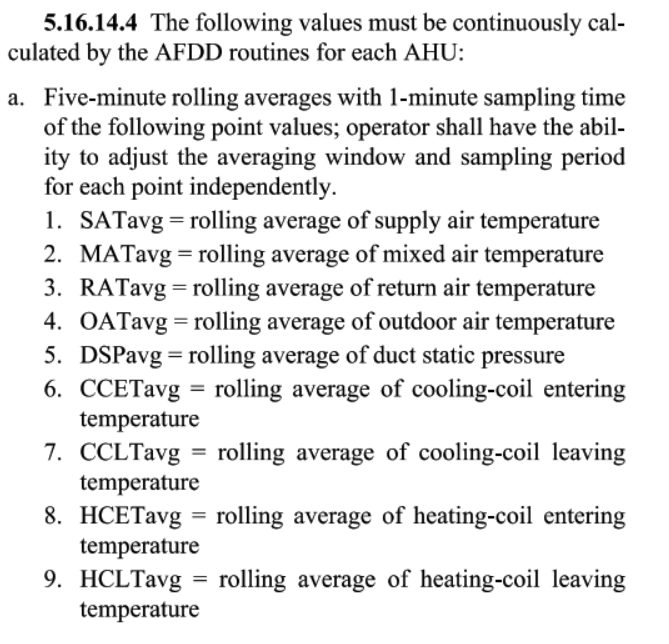

In [4]:
rtu_duct_pressure_avg = rtu_duct_pressure.rolling('5T').mean()
rtu_fan_speed_avg = rtu_fan_speed.rolling('5T').mean()

In [5]:
# combine duct pressure and fan speed datasets
fc1_dataset = rtu_duct_pressure_avg.join(rtu_fan_speed_avg)

In [6]:
fc1_dataset.rename(columns={'slipstream_internal/slipstream_hq/1100/Duct Static Pressure Local': 'duct_static', 
                   'slipstream_internal/slipstream_hq/1100/Duct Static Pressure Setpoint Active': 'duct_static_setpoint',
                   'slipstream_internal/slipstream_hq/1100/Supply Fan Speed Command': 'vfd_speed'}, inplace=True)

In [7]:
fc1_dataset.columns

Index(['duct_static', 'duct_static_setpoint', 'vfd_speed'], dtype='object')

# Plot data for visulation 

<AxesSubplot:title={'center':'RTU Duct Static Pressure and Setpoint'}, xlabel='Time'>

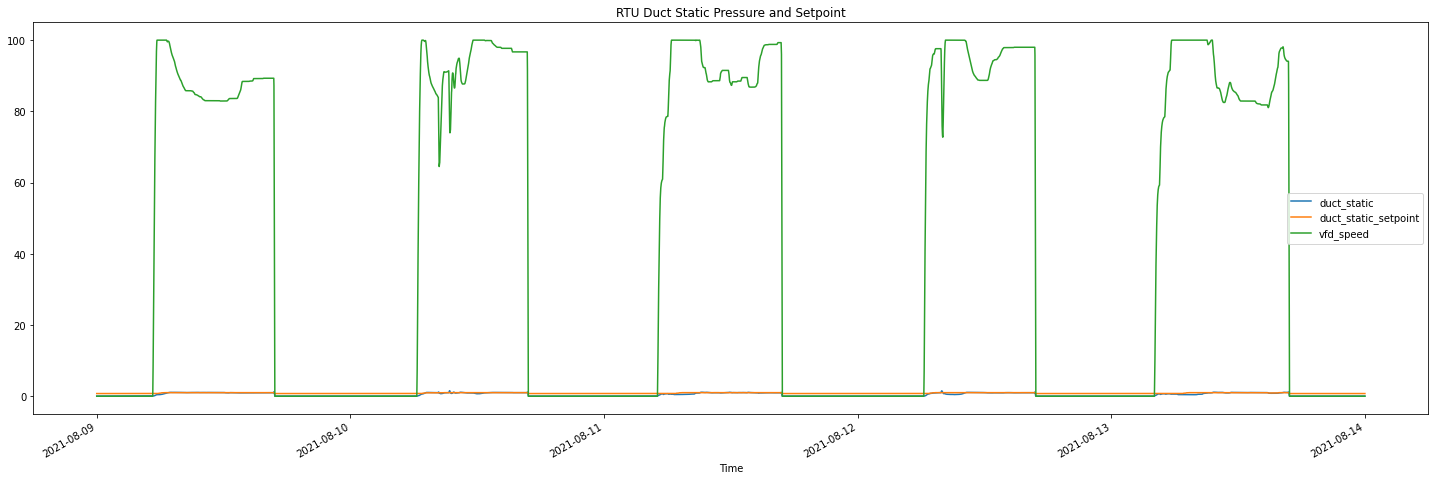

In [8]:
fc1_dataset.plot(figsize=(25,8), title='RTU Duct Static Pressure and Setpoint')

# Set Internal VAV AHU AFDD Variables per G36 Spec Imperial Units

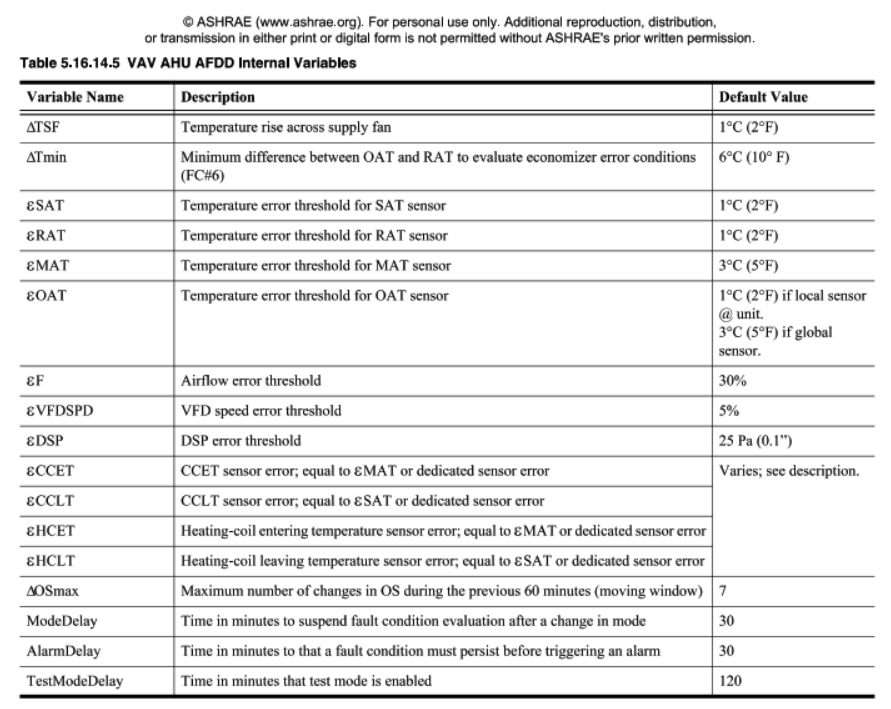

In [9]:
supply_fan_delta_degf = 2
oat_rat_delta_degf_min = 10
supply_degf_err_thres = 2
return_degf_err_thres = 2
mix_degf_err_thres = 5
outdoor_degf_err_thres = 5
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7
mode_delay = 30
alarm_dely = 30
test_mode_delay = 120 

In [10]:
# make an entire column out of these params
fc1_dataset['vfd_speed_percent_err_thres'] = vfd_speed_percent_err_thres
fc1_dataset['duct_static_inches_err_thres'] = duct_static_inches_err_thres
fc1_dataset['vfd_speed_percent_max'] = vfd_speed_percent_max

In [11]:
fc1_dataset.columns

Index(['duct_static', 'duct_static_setpoint', 'vfd_speed',
       'vfd_speed_percent_err_thres', 'duct_static_inches_err_thres',
       'vfd_speed_percent_max'],
      dtype='object')

# Run dataset through the function to flag Faults

In [12]:
fc1_dataset['fc1_flag'] = fault_condition_one(fc1_dataset)

In [13]:
fc1_dataset.head()

,duct_static,duct_static_setpoint,vfd_speed,vfd_speed_percent_err_thres,duct_static_inches_err_thres,vfd_speed_percent_max,fc1_flag
Time,,,,,,,
2021-08-09 00:00:01,0.03250,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:01:01,0.03260,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:02:01,0.03270,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:03:01,0.03265,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:04:01,0.03274,0.75,0.0,0.05,0.1,0.99,False


In [14]:
# check True and False counts

fc1_dataset['fc1_flag'].value_counts()

False    5025
True     2169
Name: fc1_flag, dtype: int64

In [15]:
# change boolean column to int for plots

fc1_dataset['fc1_flag'] = fc1_dataset['fc1_flag'].astype(int)

# drop params column for better plot
fc1_dataset = fc1_dataset.drop(['vfd_speed_percent_err_thres',
                  'duct_static_inches_err_thres',
                  'vfd_speed_percent_max'],axis=1)


<AxesSubplot:title={'center':'FC 1 Test'}, xlabel='Time'>

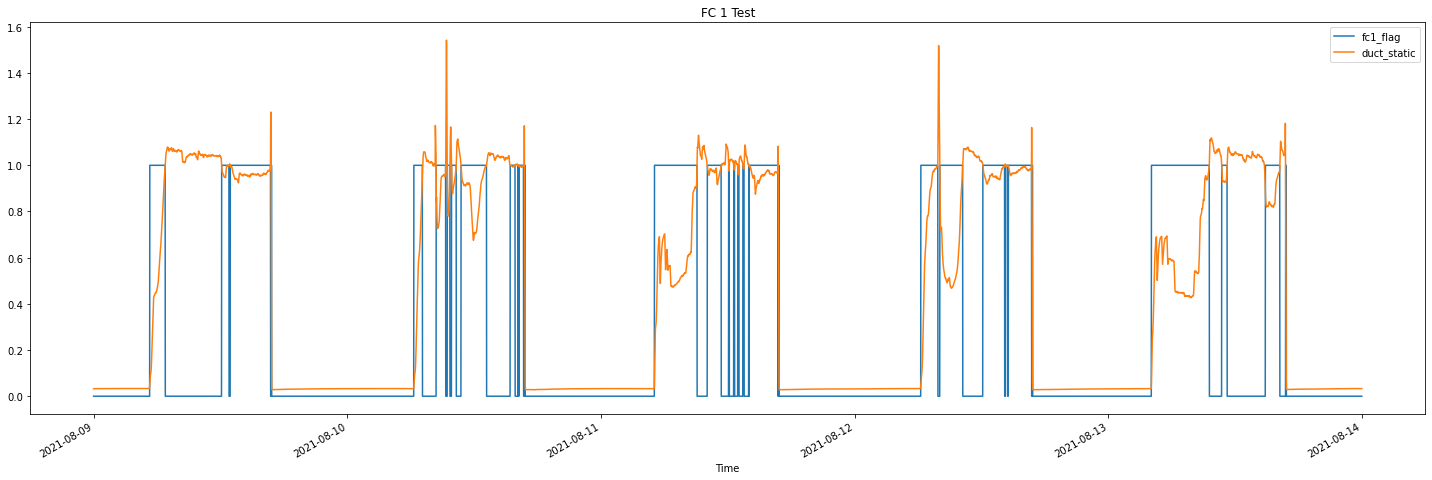

In [16]:
fdd_plot = fc1_dataset[['fc1_flag','duct_static']]

fdd_plot.plot(figsize=(25,8),title='FC 1 Test')

# Calculate percent TRUE AND FALSE of FDD Flag

In [17]:
percent_true = fdd_plot.fc1_flag.mean()

percent_true

0.30150125104253545

In [18]:
percent_false = 1 - percent_true

percent_false

0.6984987489574646

# Calculate elapsed time for fault conditions True

In [19]:
# https://stackoverflow.com/questions/31517728/python-pandas-detecting-frequency-of-time-series/43963919#:~:text=the%20minimum%20time%20difference%20is%20found%20with

In [20]:
np.diff(fdd_plot.index.values).mean()

numpy.timedelta64(60050048658,'ns')

In [21]:
freq = 1e9 / np.diff(fdd_plot.index.values).mean().astype(int)

freq

-12.579647092090037

In [22]:
fdd_plot.fc1_flag.sum()

2169

In [23]:
fdd_plot['time'] = pd.to_timedelta(fdd_plot.index)

TypeError: dtype datetime64[ns] cannot be converted to timedelta64[ns]

In [ ]:
import pandas as pd
import numpy as np

# simulate some data
# ===================================
np.random.seed(0)
dt_rng = pd.date_range('2015-03-02 00:00:00', '2015-07-19 23:00:00', freq='T')
dt_idx = pd.DatetimeIndex(np.random.choice(dt_rng, size=2000, replace=False))
df = pd.DataFrame(np.random.randn(2000), index=dt_idx, columns=['col']).sort_index()

df

In [ ]:
df['elapsed_time'] = pd.TimedeltaIndex(df)